In [2]:
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# figure beautification
sns.set_theme(
    style='whitegrid',
    palette='deep',
    color_codes=True # access seaborn colors by changing matplotlib color shorthands
)
%config InlineBackend.figure_format = 'retina'

In [3]:
# load ice thickness data
icevol_change = {}
anom_type = ['deltaT', 'deltaT_deltaP']
anom_vals = ['+3', '+6', '+9', '+12']

# get reference ice volume from different directory structure
data = np.load('reference/simulation-data.npz')
icevol_ref = data['h'][-1] * 40 * 40 / 1e3

# the dummy list for the map ice thickness has to be
# initialized manually with the following dimensions:
ll = np.empty((5, 41, 70))
for t in anom_type:
    # add reference ice volume to the list
    ll[0,:,:] = icevol_ref
    for i, val in enumerate(anom_vals):
        data = np.load(f'{t}/{val}/simulation-data.npz')
        # load ice thickness of final time step
        # & convert to ice volume change in km^3
        ll[i+1,:,:] = data['h'][-1] * 40 * 40 / 1e3
    icevol_change[t] = ll - icevol_ref

### Change in total ice volume vs temperature anomaly

In [4]:
# calculate total ice volume change
icevol_change_sum = {}
for t in anom_type:
    icevol_change_sum[t] = np.sum(icevol_change[t], axis=(1,2))

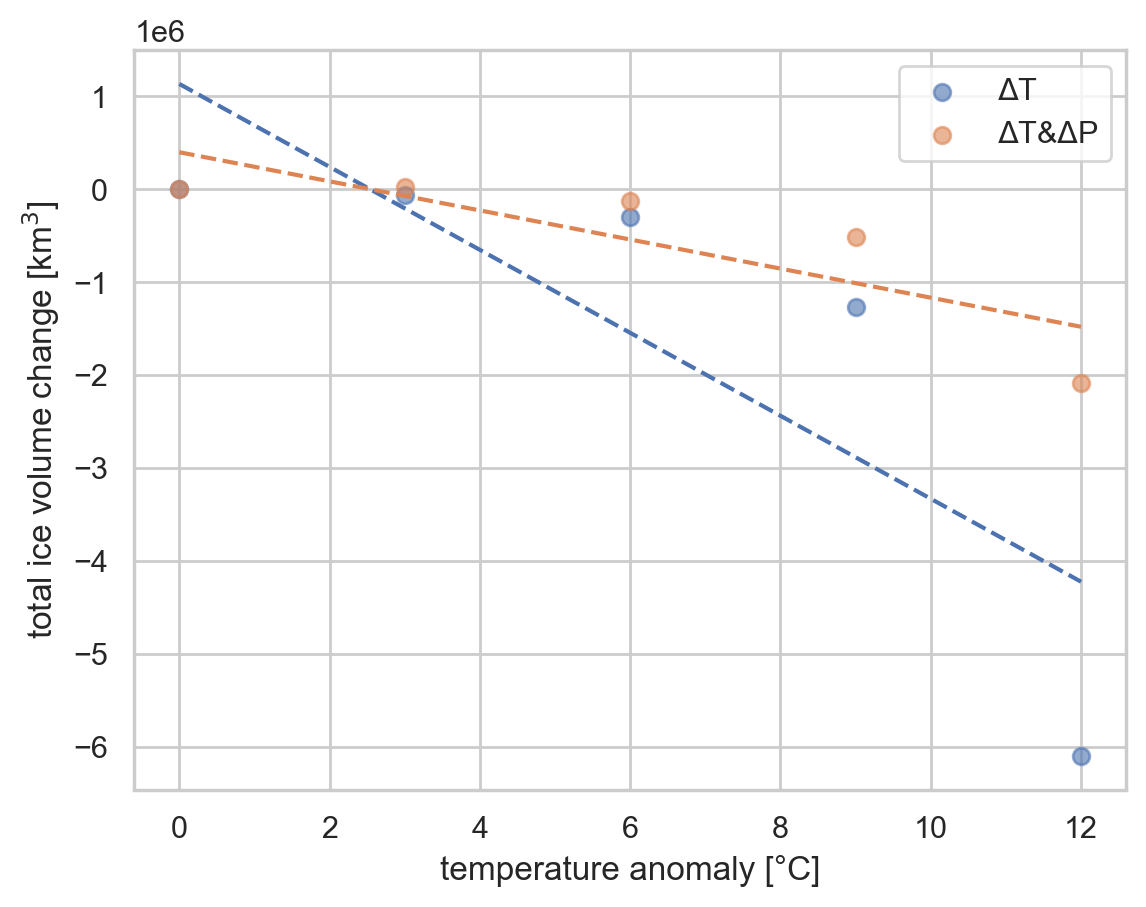

In [9]:
fig, ax = plt.subplots()
t_change = np.arange(0, 12+1, 3) # temperature anomalies in °C

for t, label in zip(anom_type, [r'$\Delta$T', r'$\Delta$T&$\Delta$P']):
    ax.scatter(t_change, icevol_change_sum[t], label=label, alpha=.6)

    # perform a least squares regression with a polynomial of degree 1 (linear regression)
    coefficients = np.polyfit(t_change, icevol_change_sum[t], 1)
    # create a set of x values for the regression line
    x_values = np.linspace(min(t_change), max(t_change), 100)
    # compute the corresponding y values for the regression line
    y_values = np.polyval(coefficients, x_values)
    # plot the regression line
    ax.plot(x_values, y_values, ls='--')

ax.set_xlabel('temperature anomaly [°C]')
ax.set_ylabel('total ice volume change [km$^3$]')
ax.legend()
plt.savefig('figs/icevol-deltat.png', dpi=300, bbox_inches='tight')

### Maps of linear trend

Repeating the linear regression for every grid cell.

In [6]:
trend = {}
for t in anom_type:
    tt = np.empty((41, 70))
    for ilat in range(41):
        for jlon in range(70):
            # just keep the slope of the linear regression
            tt[ilat,jlon], _ = np.polyfit(t_change[:-1], icevol_change[t][:-1,ilat,jlon], 1)
    trend[t] = tt

In [7]:
# find max ice thickness for color normalization
# & apply ocean mask
data = np.load('reference/simulation-data.npz')
seamask = data['seamask'][-1]
trend_masked = {}

for t in anom_type:
    # apply ocean mask to ice thickness
    trend_masked[t] = np.ma.masked_array(trend[t], mask=seamask)
    print(t)
    print(f'max: {np.max(trend_masked[t])} km^3/°C')
    print(f'min: {np.min(trend_masked[t])} km^3/°C')

deltaT
max: 21.86846360521484 km^3/°C
min: -534.3290532017446 km^3/°C
deltaT_deltaP
max: 52.097465121838205 km^3/°C
min: -536.0951275837051 km^3/°C


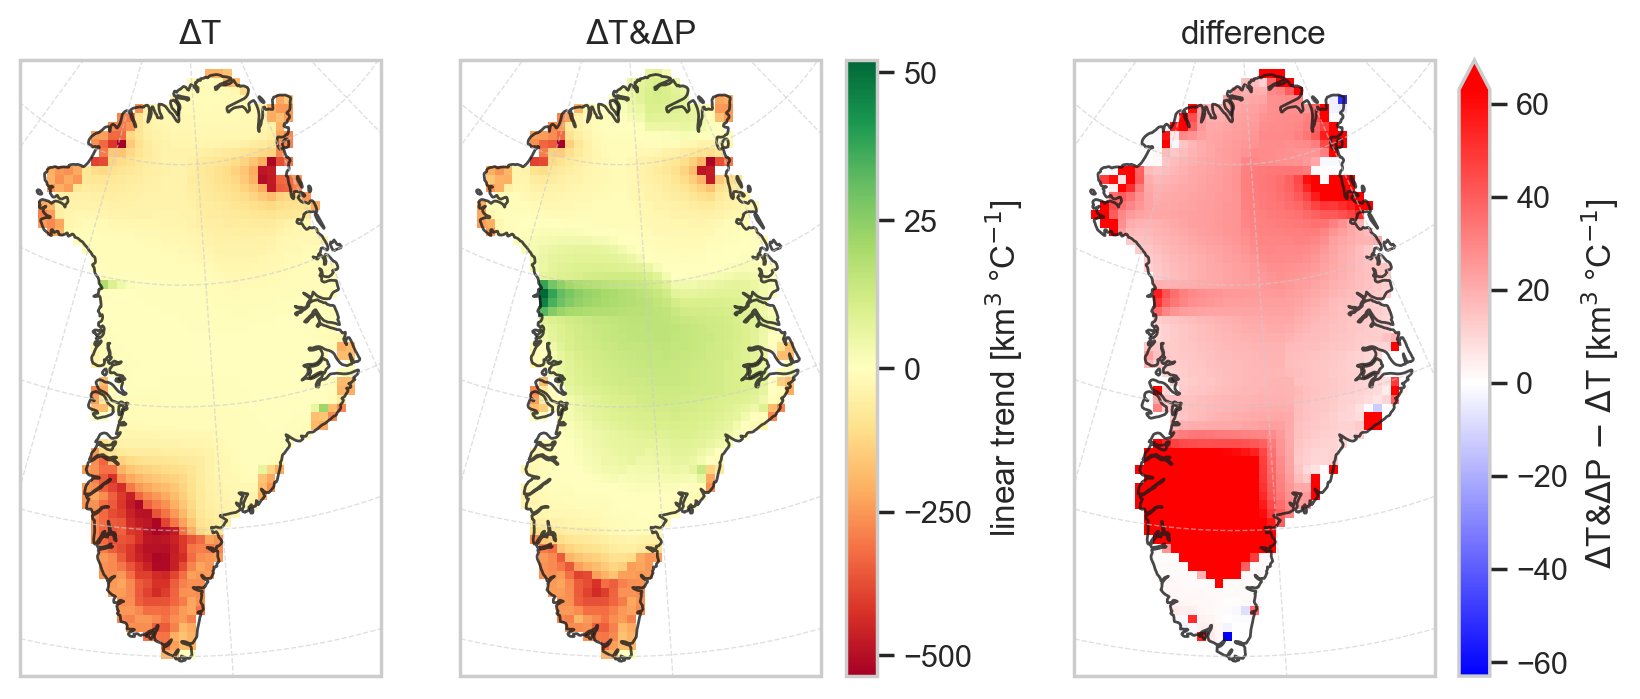

In [13]:
xlon    = data['xlon']
ylat    = data['ylat']

# plot greenland ice thickness map
trans = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo(central_longitude=-44)
fig, axs = plt.subplots(1, 3, figsize=(10, 4),
                        subplot_kw=dict(projection = proj), gridspec_kw={'wspace': 0.1})
# add coastline of greenland
# get path to shapefile
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
# read shapefile
shpfile = shpreader.Reader(shpfilename)
# select greenland only
greenland = [country.geometry for country in shpfile.records() \
             if country.attributes["NAME_LONG"] == "Greenland"]

# optionally, adjust colorbar ticks of linear trend
cbar_ticks=[-500, -250, 0, 25, 50]

subtitles = [r'$\Delta$T', r'$\Delta$T&$\Delta$P']
for i, t, subtitle in zip(range(2), anom_type, subtitles):
    ax = axs[i]
    cm = ax.pcolormesh(xlon, ylat, trend_masked[t], cmap='RdYlGn',
                       shading='nearest', transform=trans,
                       norm = mpl.colors.TwoSlopeNorm(vcenter=0,
                                                      vmin=np.min(trend_masked['deltaT_deltaP']),
                                                      vmax=np.max(trend_masked['deltaT_deltaP'])))
    ax.set_title(subtitle)
    # add greenland coastline
    ax.add_geometries(greenland, crs=trans, fc='none', ec='k', alpha=0.8)
    ax.gridlines(alpha=.6, ls='--', lw=.5)
cbar = fig.colorbar(cm, ax=axs[:2], ticks=cbar_ticks, pad=0.025)
cbar.set_label(r'linear trend [km$^3$ °C$^{-1}$]')

# difference between scenarios
trend_diff = trend['deltaT_deltaP']-trend['deltaT']
trend_diff_masked = np.ma.masked_array(trend_diff, mask=seamask)
cm2 = axs[2].pcolormesh(xlon, ylat, trend_diff_masked, 
                        shading='nearest', transform=trans, cmap='bwr',
                        norm=mpl.colors.CenteredNorm(halfrange=np.min(trend_diff_masked)))
# add greenland coastline
axs[2].add_geometries(greenland, crs=trans, fc='none', ec='k', alpha=0.8)
axs[2].gridlines(alpha=.6, ls='--', lw=.5)
axs[2].set_title('difference')
cbar = fig.colorbar(cm2, extend='max', ax=axs[2])
cbar.set_label(r'$\Delta$T&$\Delta$P $-$ $\Delta$T [km$^3$ °C$^{-1}$]')

plt.savefig('figs/linear-trend.png', dpi=300, bbox_inches='tight')